In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics                    import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection            import KFold, train_test_split
from sklearn.compose                    import ColumnTransformer
from sklearn.pipeline                   import Pipeline
from sklearn.impute                     import SimpleImputer
from sklearn.preprocessing              import StandardScaler,OneHotEncoder,MinMaxScaler,RobustScaler,PolynomialFeatures
from category_encoders.target_encoder   import TargetEncoder
from category_encoders.cat_boost        import CatBoostEncoder
from lightgbm                           import LGBMRegressor
from xgboost                            import XGBRegressor
from catboost                           import CatBoostRegressor
from sklearn.linear_model               import LinearRegression, Lasso, Ridge
from sklearn.neighbors                  import KNeighborsRegressor
from sklearn.ensemble                   import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.tree                       import DecisionTreeRegressor
from scripts.modelos                    import Modelos
from scripts.funcoes                    import validacao, outlier

# Alterando algumas configurações de exibição do pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)
sns.set_style("whitegrid")

In [55]:
car_train = pd.read_csv('treino.csv')
car_test = pd.read_csv('teste.csv')

________


# **Definições**

Antes de iniciarmos é necessário definirmos como os nossos modelos serão avaliados. Para esse projeto vamos utilizar três métricas a seguir:

1. **Mean absolute percentage error (MAPE)**
2. **Mean absolute error (MAE)**
3. **Root mean squared log error (RMSLE)**

A nossa principal métrica sera o MAPE e tomaremos como erro aceitavel até no máximo 20%, entretanto o desejavel são erros menores que 15%.

___

# **Baseline**

Inicialmente treinaremos varios modelos de regressão com o minimo de tratamento possível da base de treino, o objetivo desse passo constitui na elaboração de uma baseline para referência.

Lembrando que nosso objetivo é construir um modelo que erre pouco, portanto, essa referência inicial é de extrema importância pois nos dará um norte.

Antes de iniciarmos vamos remover as variáveis fabricante, modelo e ano.

* Basicamente modelos novos são lançados a cada ano, portanto, qualquer modelo que não esteja nos modelos de treinamento trará problema no momento de predição. Uma possível abordagem seria criar uma classe generica onde qualquer modelo desconhecido seria configurado nessa classe generica. Como esse projeto é apenas para fins educacionais, iremos remover essa feature, porém, podemos testar novas abordagens futuramente.

* A mesma discução para a feature modelo pode ser feita para a feature fabricante. Claro que a fabricante pode dizer muito sobre o preço dos carros e pode ser sim muito interessante adicionarmos essa variável. Faremos o seguinte, inicialmente removeremos e futuramente, se necessário, incluiremos ela novamente.

* Da análise de dados observamos que as features ano_producao e idade tem o mesmo valor de coeficiente de pearson em módulo entrentanto com sinais opostos. Além disso observamos o seguinte, é muito mais interessante utilizarmos a variavel idade pois muito dificilmente vamos observar por ai carros com muito mais de 70 anos, dessa forma os valores da variável idade quase sempre estarão dentro do intervalo de idades utilizado para treinar o modelo. Isso não acontece com o ano_producao, no nosso caso o ano_producao está somente até 2019. Caso tenhamos um carro de 2020,2021,2022 ou qualquer outro ano, isso ja quebraria o modelo, é muito mais provavel que com essa variável a gente forneça inputs fora do range de treinamento do modelo. Por esse motivo estaremos removendo a variavel ano_producao.

In [56]:
car_train = car_train.drop(columns=['modelo','ano_producao'])
car_test = car_test.drop(columns=['modelo','ano_producao'])

car_train['transmissao'] = np.where(car_train['transmissao']== 'automatic',True,False).astype('bool')
car_test['transmissao'] = np.where(car_test['transmissao']== 'automatic',True,False).astype('bool')

In [57]:
X_train = car_train.drop(columns=['preco'])
y_train = car_train['preco']

X_test = car_test.drop(columns=['preco'])
y_test = car_test['preco']

In [58]:
modelo= Modelos()

modelo.AddModel([('linear regression',LinearRegression()),
('Lasso',Lasso(alpha=0.5)),
('Ridge',Ridge(alpha=1)),
('Knn',KNeighborsRegressor()),
('Random Forest',RandomForestRegressor(random_state=42,n_jobs=-1)),
('lgbm',LGBMRegressor(random_state=42)),
('xgboost',XGBRegressor()),
('Catboost',CatBoostRegressor(random_seed=42,verbose=0))])

In [59]:
var_categoricos = X_train.select_dtypes('object').columns.tolist()

var_num = X_train.select_dtypes(exclude='object').columns.tolist()

var_all = X_train.columns.tolist()

In [60]:
cat_pipe = Pipeline([('encoder',TargetEncoder()),
                        ('inputer',SimpleImputer(strategy='most_frequent'))])

num_pipe = Pipeline([('impute',SimpleImputer(strategy='median'))])


preproc = ColumnTransformer([('categoricos',cat_pipe,var_categoricos),
                             ('numericos',num_pipe,var_num)])


model_pipeline = Pipeline([('Preprocessing',preproc)])

In [61]:
modelo.FitModels(X_train,y_train,model_pipeline)

-----linear regression-----
-----Lasso-----


/home/alexandre/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.328e+11, tolerance: 1.012e+08
  model = cd_fast.enet_coordinate_descent(


-----Ridge-----
-----Knn-----
-----Random Forest-----
-----lgbm-----
-----xgboost-----
-----Catboost-----


,mae,mape,rmsle
linear regression,2117.196067,1.150264,0.000000
Lasso,2117.211255,1.150967,0.000000
Ridge,2117.275519,1.150454,0.000000
Knn,2782.263791,1.380974,0.569222
Random Forest,1145.469307,0.588369,0.129085
lgbm,1116.859103,0.543951,0.000000
xgboost,1102.896699,0.491381,0.000000
Catboost,1055.913868,0.509217,0.000000


Observamos que nessa primeira rodada os valores da metrica rmsle ficaram ruins e isso ocorreu devido que algumas fez ocasionar valores negativos nos logaritimos utilizados nessa métrica. Dessa forma olharemos para as outras duas (mae e mape)

Nosso melhor resultado sem basicamente nenhum tratamento dos dados foi de 53% de erro médio com o modelo xgboost.

Vamos continuar trabalhando em cima desses dados para que possamos alcançar melhores resultados, para isso vamos utilizar os resultados do xgboost para explorar o que podemos melhorar

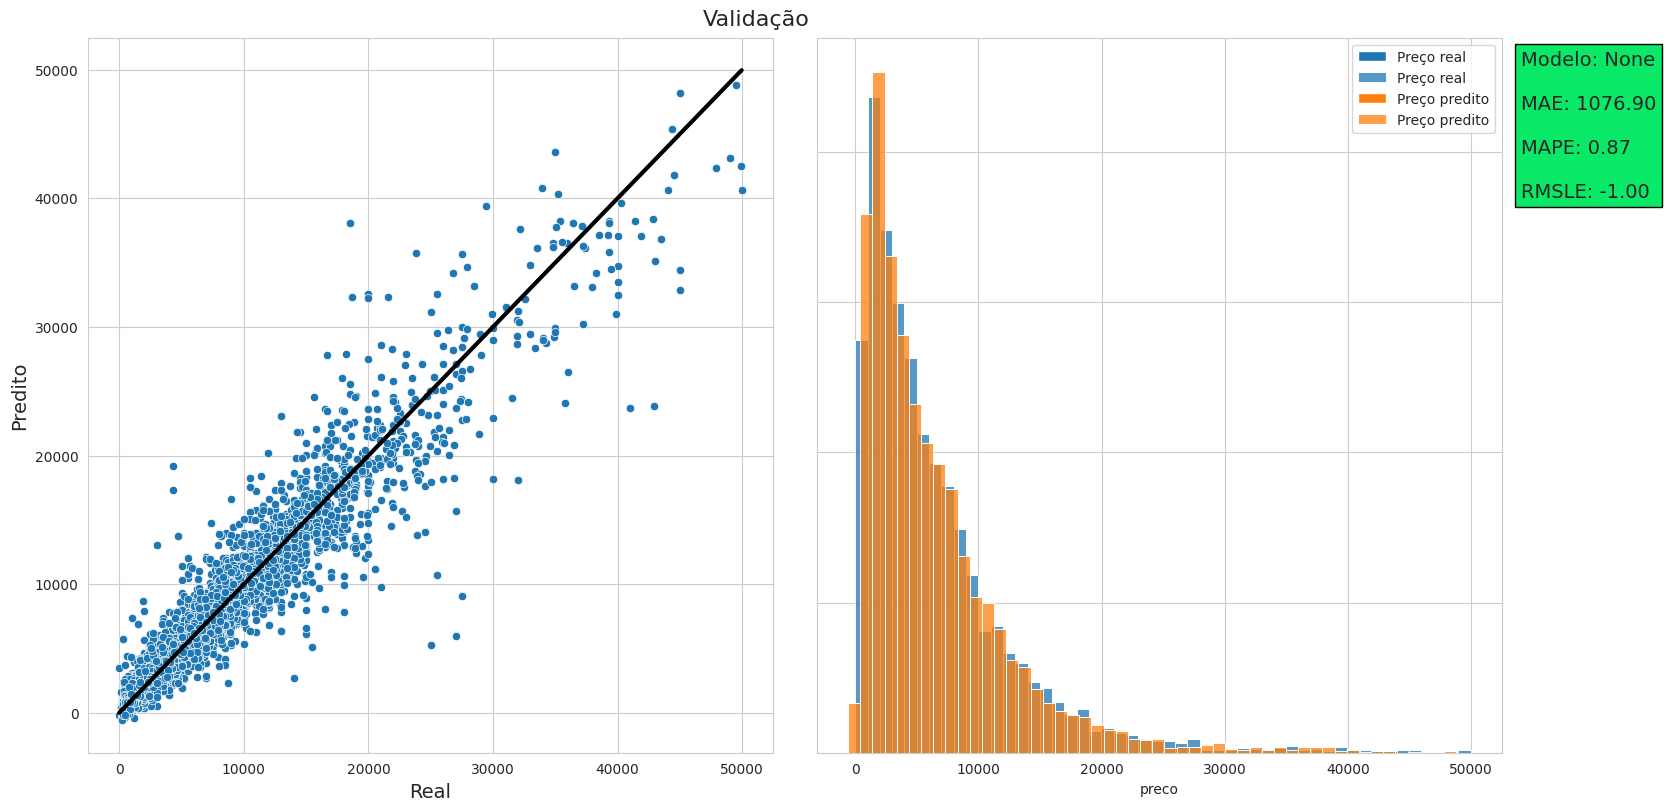

In [62]:
predito , real, _ = modelo.FitoneModel(X = X_train,y = y_train,pipe = model_pipeline,nome = 'xgboost')

validacao(real,predito)

______

# **Modelando**

Já foi notado que o preço é uma variavel assimétrica a direita, dessa forma sabemos que essa é constituida de valores discrepantes. Uma estratégia seria identificar e remover esses valores, entretanto, antes de remover vamos aplicar o logaritmo na variável preço. Com essa transformação a variavel preço se tornará mais simétrica e a variável idade será linearizada, da análise da dados observamos seu comportamento não linear.

In [63]:
modelo.FitModels(X_train,y_train,model_pipeline,log_y=True)

-----linear regression-----
-----Lasso-----
-----Ridge-----
-----Knn-----
-----Random Forest-----
-----lgbm-----
-----xgboost-----
-----Catboost-----


,mae,mape,rmsle
linear regression,1639.388521,0.532097,0.196745
Lasso,2444.306772,0.705708,0.358720
Ridge,1639.230041,0.532029,0.196721
Knn,3294.440274,1.095103,0.668362
Random Forest,1137.601512,0.457308,0.115472
lgbm,1131.773202,0.471947,0.107795
xgboost,1090.885679,0.458960,0.110843
Catboost,1058.533009,0.453224,0.102430


Nosso erro de 53\% caiu para +- 46\% apenas com a aplicação do logaritmo na variável alvo e observamos também que o erro dos modelos lineares cairam em uma quantia razoavel. 

No notebook de análise iremos exibir o que acontece com o preço e algumas outras variáveis depois dessa transformação.

## **Vamos adicionar um scaler**

Apesar de não ter muito sentido aplicarmos scaler em arvore, vamos tentar mesmo assim e comparar os resultados

In [64]:
cat_pipe = Pipeline([('encoder',TargetEncoder()),
                        ('inputer',SimpleImputer(strategy='most_frequent'))])

num_pipe = Pipeline([('impute',SimpleImputer(strategy='median')),
                     ('sccaler',StandardScaler())])


preproc = ColumnTransformer([('categoricos',cat_pipe,var_categoricos),
                             ('numericos',num_pipe,var_num)])


model_pipeline = Pipeline([('Preprocessing',preproc)])

modelo.FitModels(X_train,y_train,model_pipeline,log_y=True)

-----linear regression-----
-----Lasso-----
-----Ridge-----
-----Knn-----
-----Random Forest-----
-----lgbm-----
-----xgboost-----
-----Catboost-----


,mae,mape,rmsle
linear regression,1639.388521,0.532097,0.196745
Lasso,3405.387635,1.174648,0.614399
Ridge,1639.262759,0.532043,0.196726
Knn,1929.839203,0.670499,0.241440
Random Forest,1137.740916,0.457698,0.115490
lgbm,1133.800026,0.479537,0.108022
xgboost,1090.970037,0.458995,0.110875
Catboost,1058.533009,0.453224,0.102430


## **Outliers**

Mesmo aplicando o logaritmo observamos alguns valores discrepantes, vamos tentar remove-los para ver se isso ajuda nas predições

* Identificando os outliers com a variavel preço transformada

<AxesSubplot: >

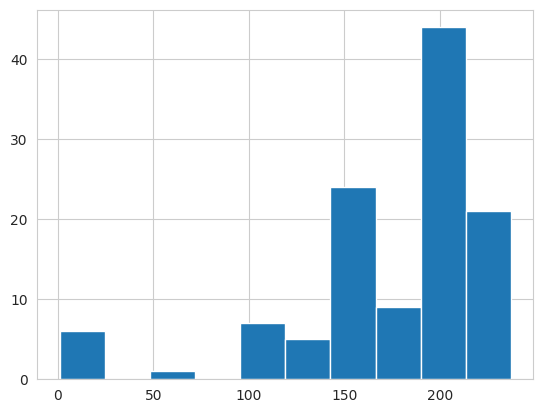

In [65]:
idx = outlier(np.log(car_train['preco']))
car_train.loc[idx,'preco'].hist();

In [66]:
without_outlier = car_train.drop(index=idx)
without_outlier = without_outlier.reset_index(drop=True)

X_train = without_outlier.drop(columns=['preco'])
y_train = without_outlier['preco']

In [67]:
car_train.shape, without_outlier.shape

((30792, 30), (30675, 30))

In [68]:
cat_pipe = Pipeline([('encoder',TargetEncoder()),
                        ('inputer',SimpleImputer(strategy='most_frequent'))])

num_pipe = Pipeline([('impute',SimpleImputer(strategy='median')),
                     ('sccaler',StandardScaler())])


preproc = ColumnTransformer([('categoricos',cat_pipe,var_categoricos),
                             ('numericos',num_pipe,var_num)])


model_pipeline = Pipeline([('Preprocessing',preproc)])

modelo.FitModels(X_train,y_train,model_pipeline,log_y=True)

-----linear regression-----
-----Lasso-----
-----Ridge-----
-----Knn-----
-----Random Forest-----
-----lgbm-----
-----xgboost-----
-----Catboost-----


,mae,mape,rmsle
linear regression,1638.755313,0.334349,0.183622
Lasso,3432.131582,0.814623,0.595602
Ridge,1638.607301,0.334312,0.183590
Knn,1932.155078,0.397684,0.224908
Random Forest,1142.332343,0.243666,0.104275
lgbm,1125.978984,0.236632,0.096071
xgboost,1092.112611,0.235257,0.097232
Catboost,1050.589217,0.226551,0.090592


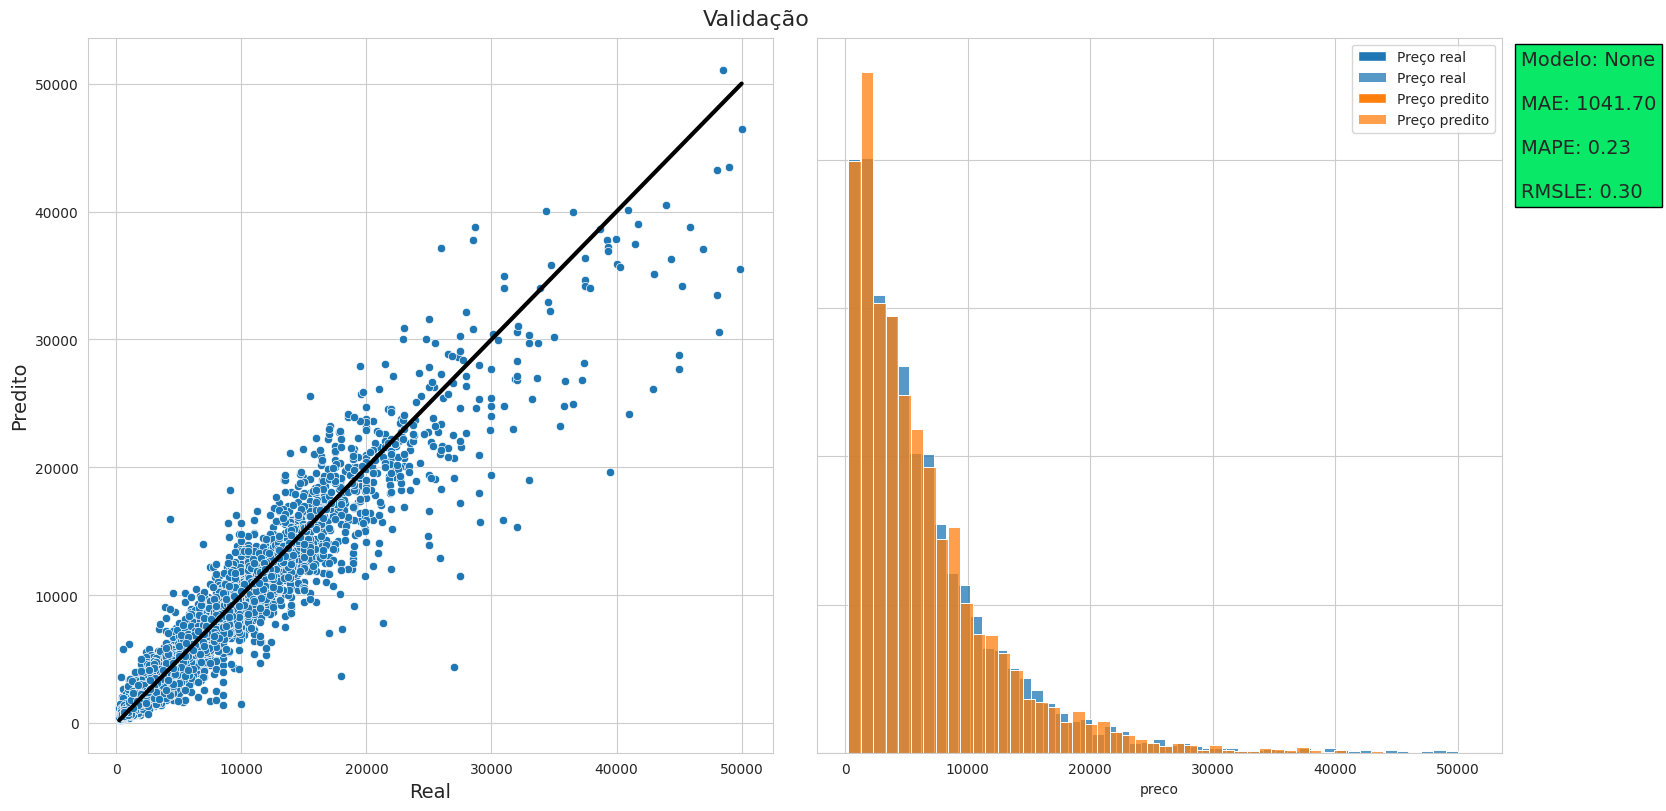

In [69]:
predito , real, avaliacao = modelo.FitoneModel(X = X_train,y = np.log(y_train),pipe = model_pipeline,nome = 'Catboost')

predito = np.exp(predito)

real = np.exp(real)

avaliacao['real'] = real
avaliacao['predito'] = predito
avaliacao['erro'] = np.abs(avaliacao['real'] - avaliacao['predito'])/avaliacao['real']

validacao(real,predito)

In [70]:
car_train = without_outlier.copy()
X_train = car_train.drop(columns=['preco'])
y_train = car_train['preco']

Vamos analisar melhor alguns pontos cujo o erro é maior que 20\%.

OBS: Estamos tomando como erro o erro percentual, isto é: 

$E(\%) = \dfrac{|Real - Predito|}{Real}$

É interessante ver que quando analisamos o erro percentual ponto a ponto observamos que de fato a média é de 23\%, como dado pela métrica MAPE. Além disso, olhar os quartis é muito mais informativo do que apenas olhar a média.

É claro que mais da metade dos dados estão com erro menor que 18\% e 75\% dos dados tem erro até 27\%.  Além disso observamos a distribuição assimétrica que explica o motivo da média estar +- 10 pontos percentuais da mediana.

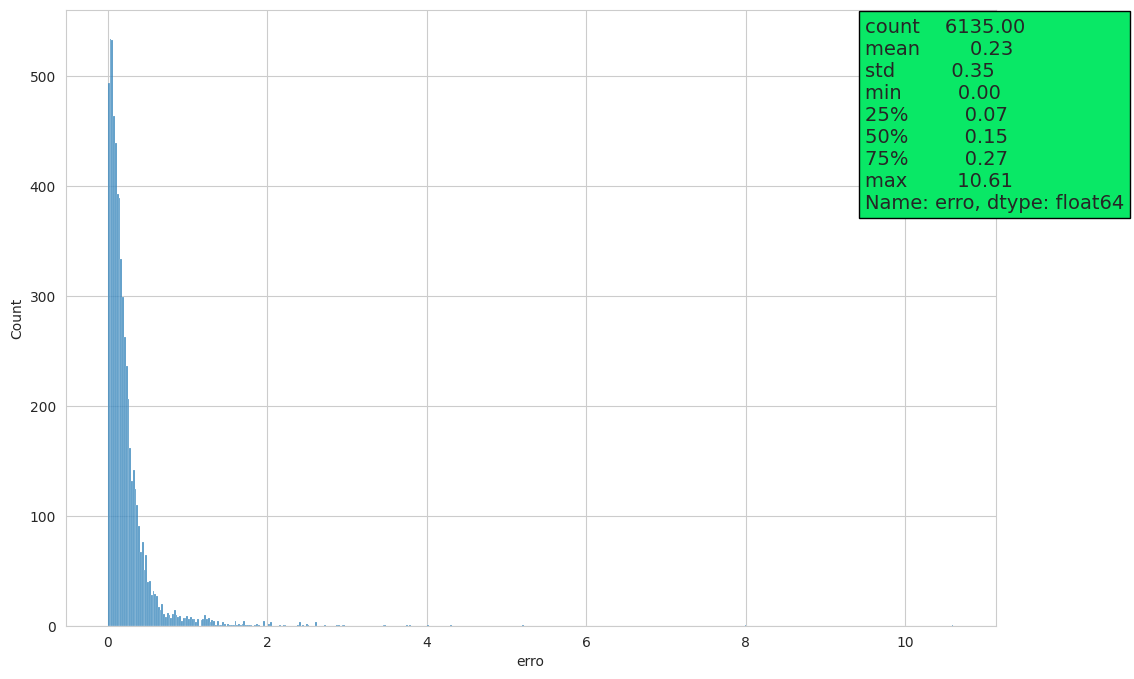

In [71]:
plt.figure(figsize=(12,8))
sns.histplot(data=avaliacao,x='erro')

texto = f"{round(avaliacao['erro'].describe(),2)}"
plt.text(9.5,380,texto,size=14,bbox=dict(boxstyle='square',ec= (0,0,0), fc= (9/255, 232/255, 102/255)));

Ao remover o scaler nós observamos que não há nenhuma alteração no catboost

In [72]:
cat_pipe = Pipeline([('encoder',TargetEncoder()),
                        ('inputer',SimpleImputer(strategy='most_frequent'))])

num_pipe = Pipeline([('impute',SimpleImputer(strategy='median'))])


preproc = ColumnTransformer([('categoricos',cat_pipe,var_categoricos),
                             ('numericos',num_pipe,var_num)])


model_pipeline = Pipeline([('Preprocessing',preproc)])


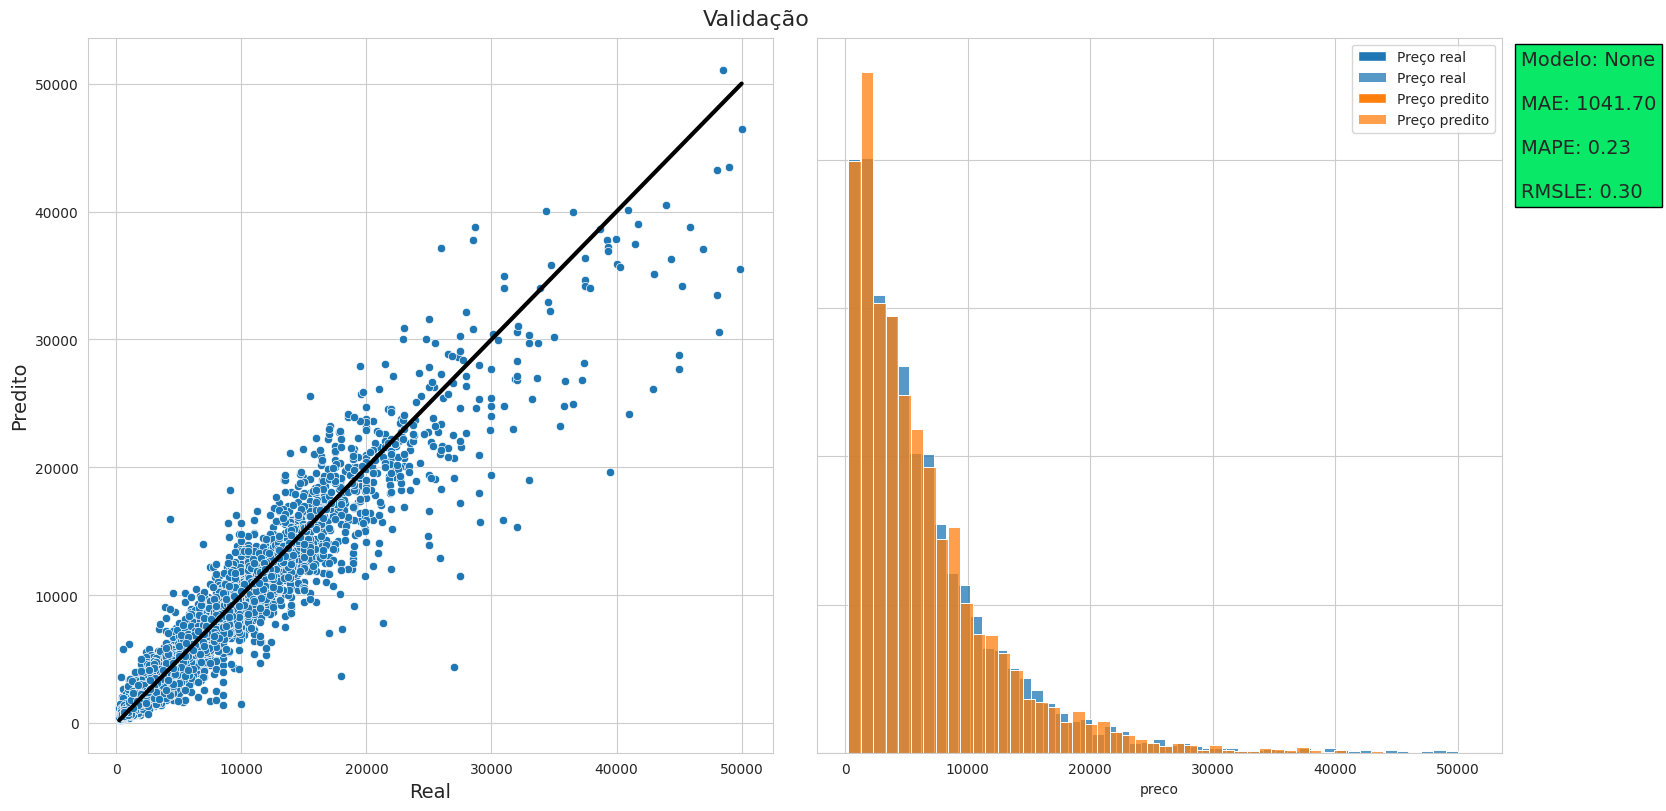

In [73]:
predito , real, avaliacao = modelo.FitoneModel(X = X_train,y = np.log(y_train),pipe = model_pipeline,nome = 'Catboost')

predito = np.exp(predito)

real = np.exp(real)

avaliacao['real'] = real
avaliacao['predito'] = predito
avaliacao['erro'] = np.abs(avaliacao['real'] - avaliacao['predito'])/avaliacao['real']

validacao(real,predito)

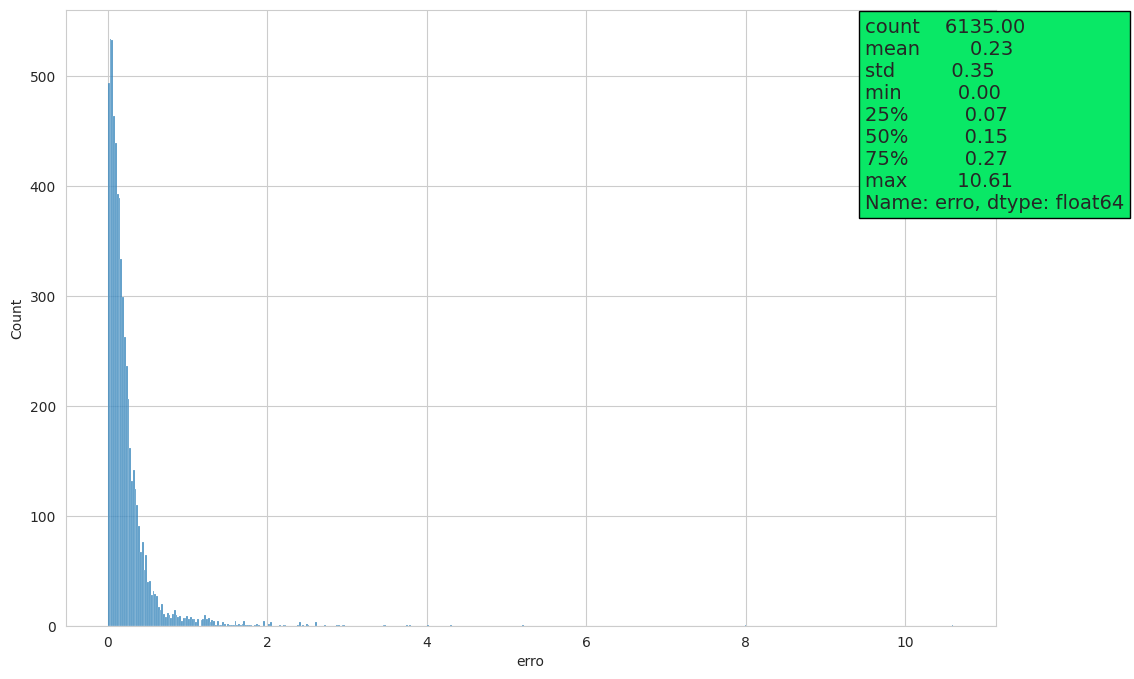

In [74]:
plt.figure(figsize=(12,8))
sns.histplot(data=avaliacao,x='erro')

texto = f"{round(avaliacao['erro'].describe(),2)}"
plt.text(9.5,380,texto,size=14,bbox=dict(boxstyle='square',ec= (0,0,0), fc= (9/255, 232/255, 102/255)));

# **Validação**

Obtemos um modelo que julgamos interessante, portanto, agora é o momento ideal para realizarmos as predições no nosso conjunto de teste

In [75]:
model_pipeline.steps.pop()
model_pipeline.steps.append(('modelo',modelo.models['Catboost']))
reg = model_pipeline

In [77]:
reg.fit(X_train,np.log(y_train))

predito = np.exp(reg.predict(X_test))


avaliacao = X_test.copy()

avaliacao['real'] = y_test.copy()
avaliacao['predito'] = predito
avaliacao['erro'] = np.abs(avaliacao['real'] - avaliacao['predito'])/avaliacao['real']


avaliacao['erro'].describe()

avaliacao_base = avaliacao.copy()

Ao comparar as estátisticas descritivas do erro percentual observamos que em média eles são diferentes, mas ao observar os quartis observamos que estão basicamente identicos o que parece que de um modo geral nosso modelo foi bem treinado. O fato do erro médio ser diferente reside em algumas predições que literalmente são outliers. Portanto, na mediana, nosso erro está em 14,3\%.


Agora vamos analisar as nossas predições para podermos entender melhor a nossa solução e até mesmo sugerir modificações

# **Uma breve análise acerca dos resultados**

In [78]:
total_linhas = avaliacao.shape[0]
maior_100 = avaliacao.query('erro > 1')
print(f"Houve {maior_100.shape[0]} predições cujo o erro percentual foi maior que 100% e isso corresponde a {maior_100.shape[0]/total_linhas * 100:.2f}% do dataset de validação")

Houve 210 predições cujo o erro percentual foi maior que 100% e isso corresponde a 2.73% do dataset de validação


Através da estatistica descritiva observamos veiculos cujo o preço é um dolar, vamos investigar isso melhor.

In [79]:
maior_100.describe().T

,count,mean,std,min,25%,50%,75%,max
odometro,210.0,258256.619048,156959.331649,11.000000,142500.000000,259500.000000,344288.250000,1000000.000000
capacidade_motor,210.0,1.931905,0.508757,0.800000,1.600000,1.900000,2.100000,5.400000
n_fotos,210.0,7.266667,4.839563,1.000000,4.000000,6.000000,9.000000,30.000000
atualizacoes,210.0,10.471429,26.081243,1.000000,1.000000,3.000000,9.750000,222.000000
dias_listado,210.0,70.157143,106.957082,0.000000,15.000000,47.500000,87.000000,1243.000000
idade,210.0,25.747619,8.701214,5.000000,22.000000,25.000000,28.000000,59.000000
qt_combustivel,210.0,1.042857,0.203019,1.000000,1.000000,1.000000,1.000000,2.000000
real,210.0,666.285714,531.485244,1.000000,333.487500,500.000000,800.000000,3200.000000
predito,210.0,1764.650445,1418.508454,420.110094,825.993579,1291.963697,2279.697434,10002.110312
erro,210.0,6.676445,50.439598,1.001651,1.200126,1.446354,2.122123,589.541875


Um caso interessante de se observar são nos erros exepcionalmente grandes e logo de cara entendemos o motivo dessas predições terem um erro enorme, trata-se que esses 2 registros tem o preço de \$1 dolar, isso é, não se trata do preço verdadeiro do carro. Entretanto, observamos que ambos os veículos estão com algum defeito, ou que o vendedor desse carro esta sujeito a negociações e por isso colocou o preço do carro a \$1 dolar apenas por simbolismo. Portanto, podemos concluir que esses carros são literalmente um ruido para nosso modelo.


Observação:  Nosso objetivo aqui é analisar os nossos erros, entretanto, se esse modelo estivesse em produção saberiamos, dentro de uma faixa de erro, qual seria o preço real desses dois veículos e isso serviria de base para podermos negociar.

In [80]:
maior_100.query('erro > 10')[['fabricante','estado','real','predito','erro']]

,fabricante,estado,real,predito,erro
1664,Fiat,emergency,1.0,439.944625,438.944625
3064,Peugeot,emergency,1.0,590.541875,589.541875


Agora que identificamos um dos problemas, vamos analisar a parcela dos dados cujo o erro é maior que 20\% e menor do que esses dois erros que determinamos na célula acima.

In [81]:
erros  =  avaliacao.query('erro > 0.2 and erro <10')

print(f"Houve {erros.shape[0]} predições cujo o erro percentual está entre 20%-10000% e isso corresponde a {erros.shape[0]/total_linhas * 100:.2f}% do dataset de validação")

Houve 2774 predições cujo o erro percentual está entre 20%-10000% e isso corresponde a 36.03% do dataset de validação


In [82]:
erros.describe().T

,count,mean,std,min,25%,50%,75%,max
odometro,2774.0,268009.237563,144106.834878,0.000000,180000.000000,270000.000000,347000.000000,1000000.000000
capacidade_motor,2774.0,2.025739,0.642441,0.500000,1.600000,1.900000,2.200000,6.000000
n_fotos,2774.0,9.035328,6.095955,1.000000,5.000000,8.000000,11.000000,71.000000
atualizacoes,2774.0,14.953497,34.903551,1.000000,2.000000,4.000000,14.750000,699.000000
dias_listado,2774.0,80.831291,109.251215,0.000000,22.000000,59.000000,90.750000,1543.000000
idade,2774.0,19.276857,8.239766,0.000000,14.000000,20.000000,24.000000,59.000000
qt_combustivel,2774.0,1.043619,0.204283,1.000000,1.000000,1.000000,1.000000,2.000000
real,2774.0,4842.778295,6097.366801,94.850000,1300.000000,2800.000000,5839.885000,49999.000000
predito,2774.0,4595.134348,5162.173291,330.721545,1315.824902,2615.364478,5784.412482,39768.540767
erro,2774.0,0.476647,0.484219,0.200008,0.250092,0.327533,0.486043,6.352632


### **Vamos entender através do auxilio de gráfico de função acumulada algumas features numericas**

Hoje estamos em 2023 e, portanto, um carro de 25 anos foi lançado em 1998. Não me parece uma boa estratégia fazer negocio com carros tão antigos assim, obviamente cada caso é cada caso e essa é apenas a minha opnião. O correto a se fazer seria localizar dados temporais do preço de automoveis e analisar melhor essa hipótese

80% das predições com erro maior que 20% é menor ou igual a 25.00 anos


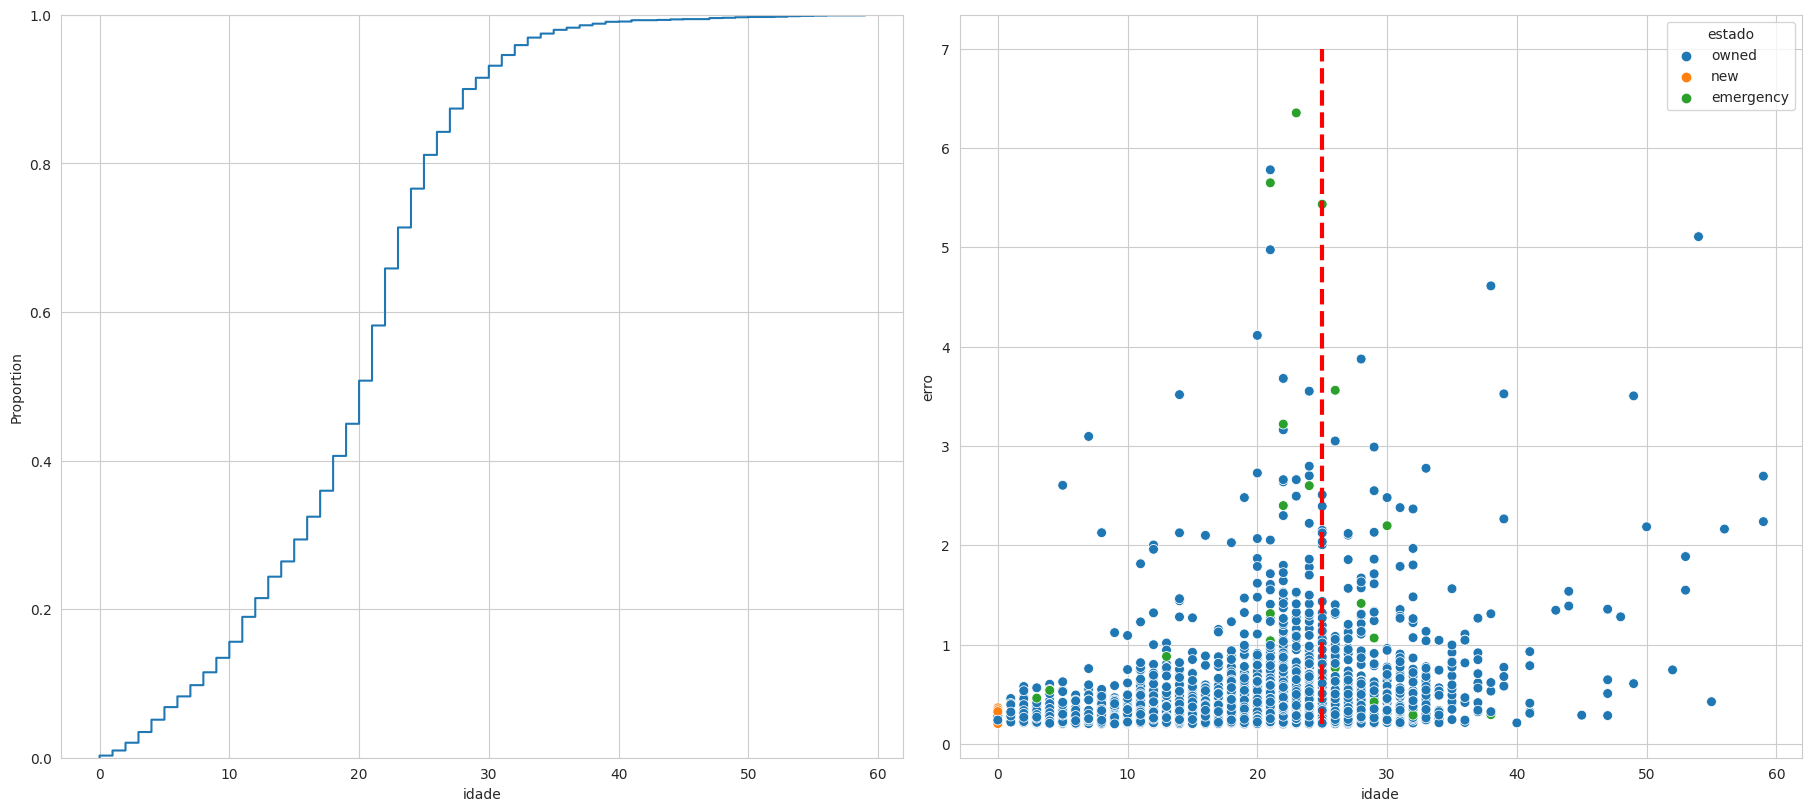

In [83]:
print(f"80% das predições com erro maior que 20% é menor ou igual a {erros['idade'].quantile(0.8):.2f} anos")

fig , ax = plt.subplots(1,2,constrained_layout=True,figsize=(18,8))

sns.ecdfplot(data=erros, x='idade',ax=ax[0]);
sns.scatterplot(data=erros, x='idade',y='erro',ax=ax[1],hue='estado',s=50);

ax[1].vlines(25,0.2,7,linestyles='dashed',linewidth=3,color='red');

Da análise descritiva dos dados observamos que o preço de um veículo diminui conforme a quiometragem do veículo, portanto, talvez devessemos evitar quilometragens grandes.

80% das predições tem a quilometragem menor igual que 360000.00Km


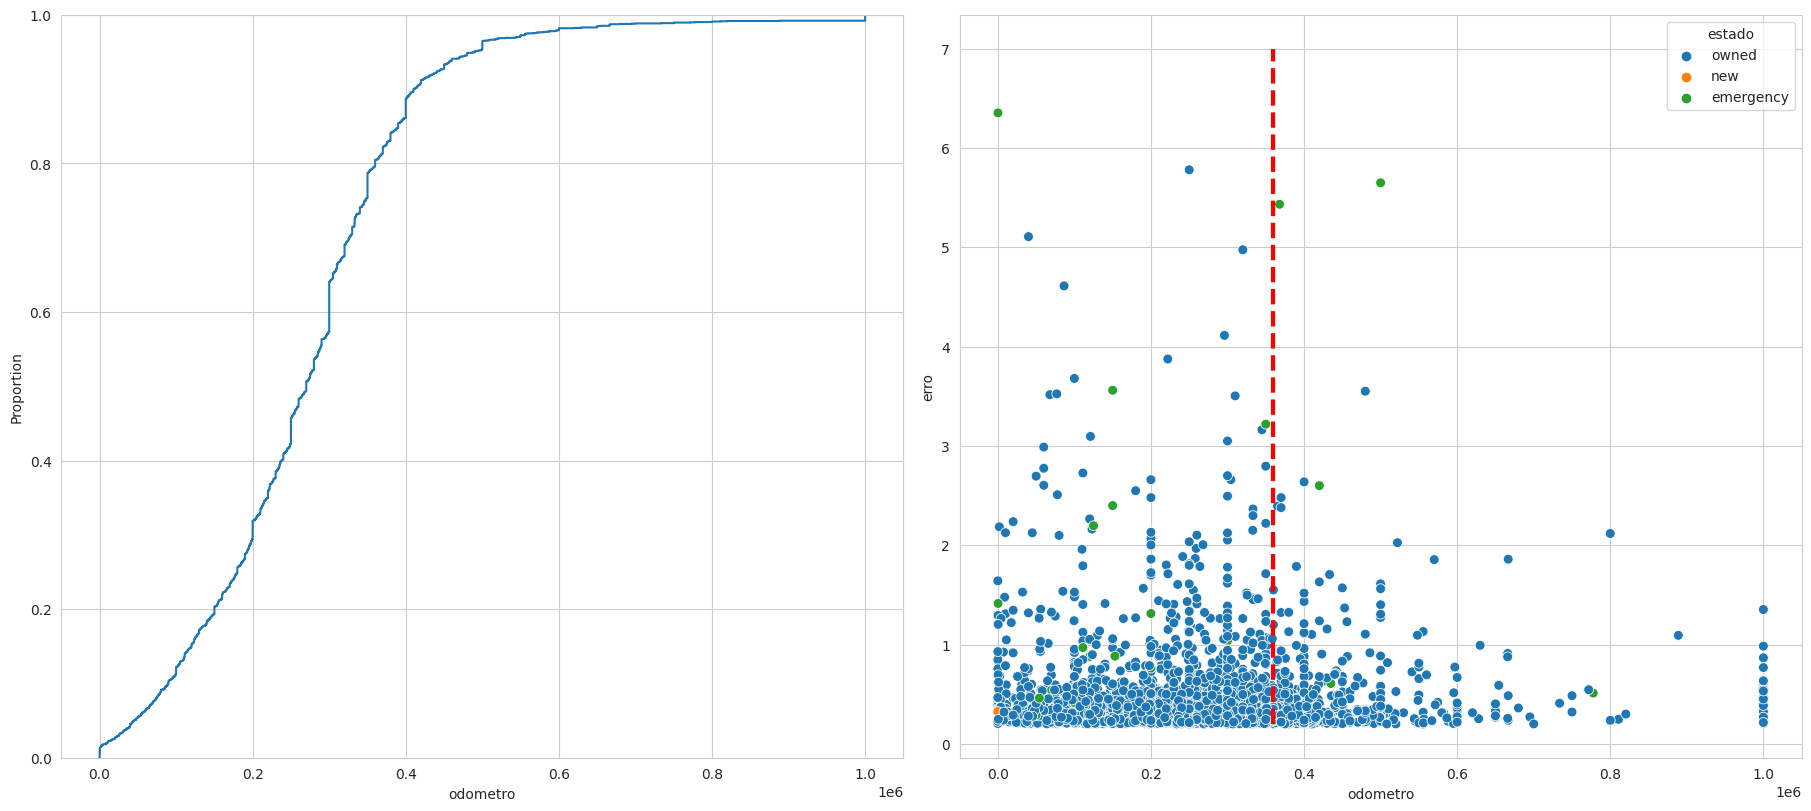

In [84]:
print(f"80% das predições tem a quilometragem menor igual que {erros['odometro'].quantile(0.8):.2f}Km")

fig , ax = plt.subplots(1,2,constrained_layout=True,figsize=(18,8))

sns.ecdfplot(data=erros, x='odometro',ax=ax[0]);
sns.scatterplot(data=erros, x='odometro',y='erro',ax=ax[1],hue='estado',s=50);

ax[1].vlines(360000,0.2,7,linestyles='dashed',linewidth=3,color='red');

É interessante observar que 80% dos preços reais onde ocorre erros maiores que 20% são menores que $7200 dolares.  

80% das predições tem o preço menor igual que $7199.40 doalares


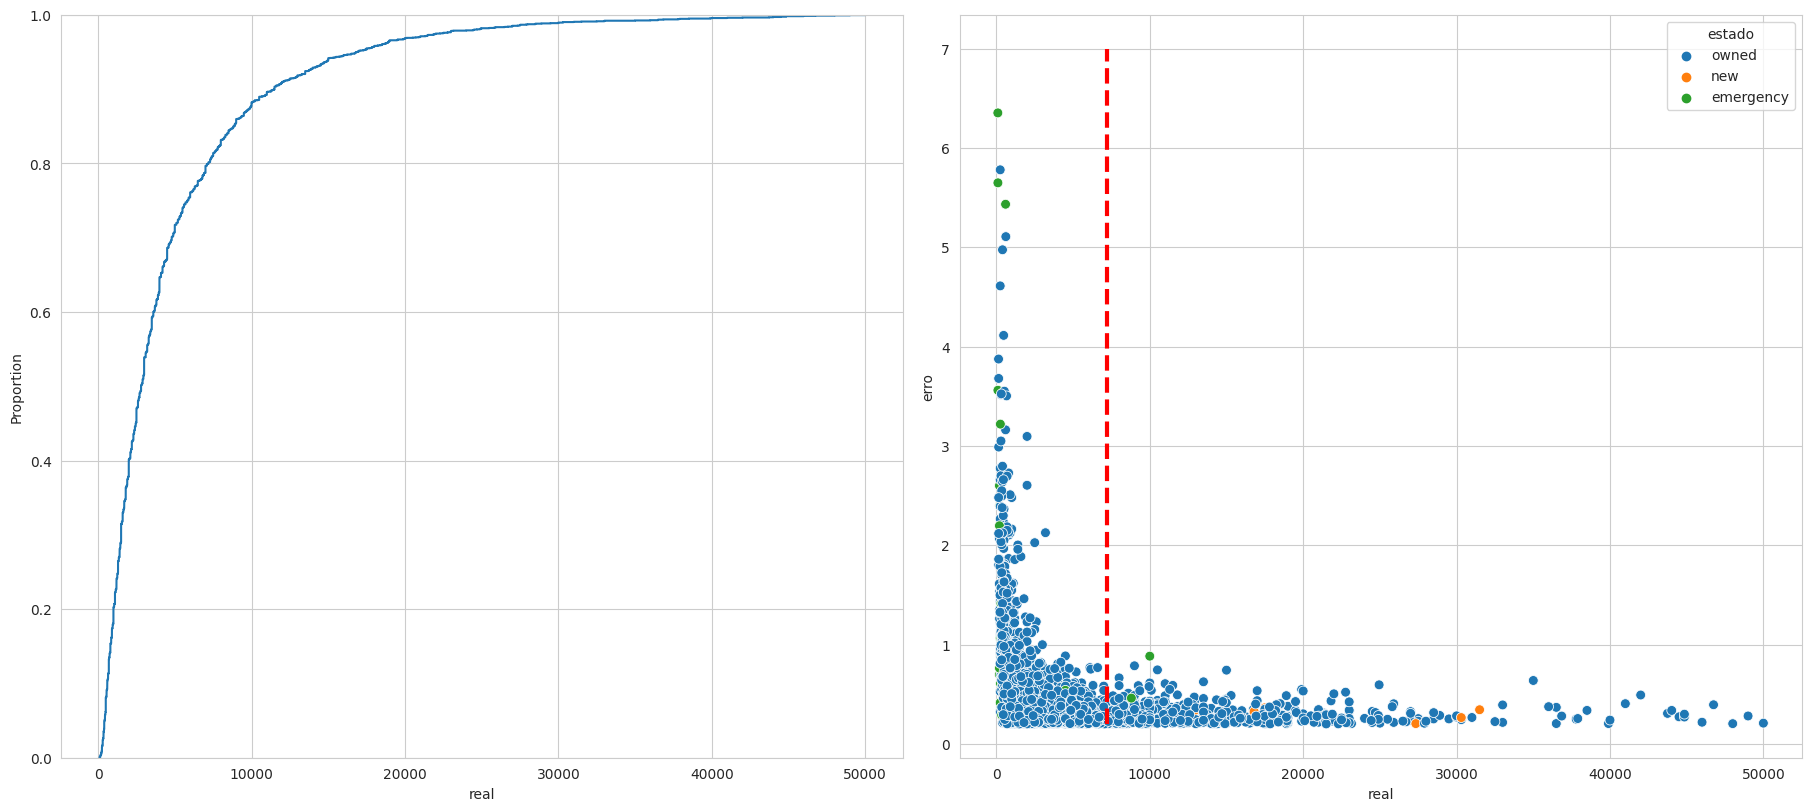

In [85]:
print(f"80% das predições tem o preço menor igual que ${erros['real'].quantile(0.8):.2f} doalares")

fig , ax = plt.subplots(1,2,constrained_layout=True,figsize=(18,8))

sns.ecdfplot(data=erros, x='real',ax=ax[0]);
sns.scatterplot(data=erros, x='real',y='erro',ax=ax[1],hue='estado',s=50);


ax[1].vlines(7199.40,0.2,7,linestyles='dashed',linewidth=3,color='red');

### **Um ponto que discutimos um pouco acima foi relacionado ao estado do veículo e comentamos sobre o fato de investir em veículos danificados talvez não fosse uma boa ideia. Vamos análisar isso**

Na mediana o erros são maiores para veículos com alguma avaria.

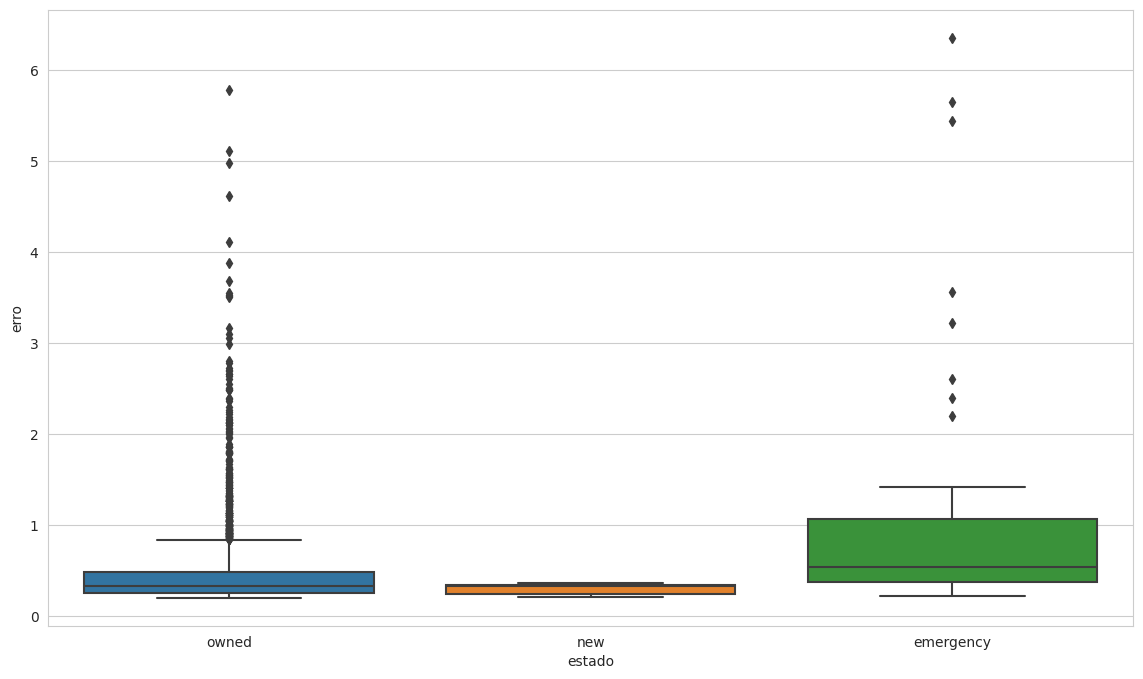

In [86]:
#print(f"80% das predições tem o preço menor igual que ${erros['estado'].quantile(0.8):.2f} doalares")
plt.figure(figsize=(14,8))
sns.boxplot(data=erros, x='estado',y='erro');

<b>Conclusão</b>

1. Existem ruidos nos dados e a avaliação de erro, por se tratar de uma média, foi prejudicada.

2. Mais de 80% dos erros maiores que 20\% se encontram em veículos com até 25 anos de idade.

3. Mais de 80% dos erros maiores que 20\% se encontram em veículos com até 360000 quilometros rodados.

4. Os erros acima de 20\% se concentram em preços mais baixos.

5. O modelo tem dificuldade em precificar veiculos com avarias.

# **Remodelando**

Levantamos alguns pontos acerca da condição do veículo, idade e quilometragem. Vamos agora limpar esses dados e retreinar nosso modelo

In [87]:
car_train = car_train.query(' estado != "emergency" and idade < 25 and odometro < 360000')
car_test = car_test.query(' estado != "emergency" and idade < 25 and odometro < 360000')

car_train = car_train.reset_index(drop=True)
car_test = car_test.reset_index(drop=True)

In [88]:
X_train = car_train.drop(columns=['preco'])
y_train = car_train['preco']

X_test = car_test.drop(columns=['preco'])
y_test = car_test['preco']

In [89]:
cat_pipe = Pipeline([('encoder',TargetEncoder()),
                        ('inputer',SimpleImputer(strategy='most_frequent'))])

num_pipe = Pipeline([('impute',SimpleImputer(strategy='median'))])


preproc = ColumnTransformer([('categoricos',cat_pipe,var_categoricos),
                             ('numericos',num_pipe,var_num)])


model_pipeline = Pipeline([('Preprocessing',preproc)])

modelo.FitModels(X_train,y_train,model_pipeline,log_y=True)

-----linear regression-----
-----Lasso-----
-----Ridge-----
-----Knn-----
-----Random Forest-----
-----lgbm-----
-----xgboost-----
-----Catboost-----


,mae,mape,rmsle
linear regression,1659.154791,0.266342,0.109225
Lasso,2805.584716,0.444957,0.252468
Ridge,1659.323833,0.266331,0.109229
Knn,3694.097685,0.725074,0.509433
Random Forest,1258.490190,0.207296,0.075956
lgbm,1224.174125,0.198981,0.068487
xgboost,1202.410207,0.197209,0.068715
Catboost,1157.779804,0.190726,0.064270


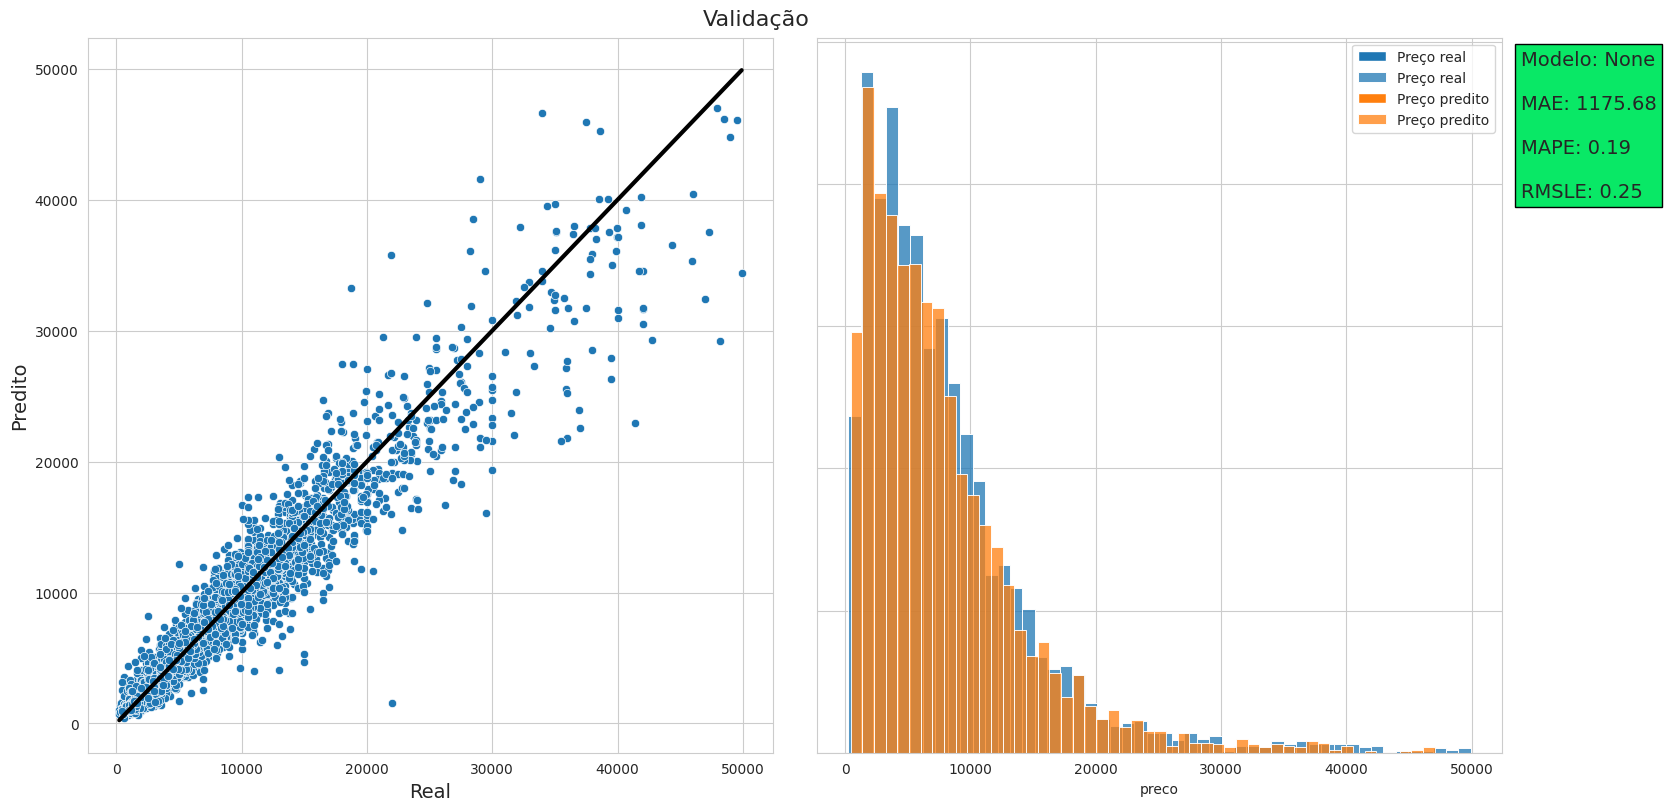

In [90]:
predito , real, avaliacao = modelo.FitoneModel(X = X_train,y = np.log(y_train),pipe = model_pipeline,nome = 'Catboost')

predito = np.exp(predito)

real = np.exp(real)

avaliacao['real'] = real
avaliacao['predito'] = predito
avaliacao['erro'] = np.abs(avaliacao['real'] - avaliacao['predito'])/avaliacao['real']

validacao(real,predito)

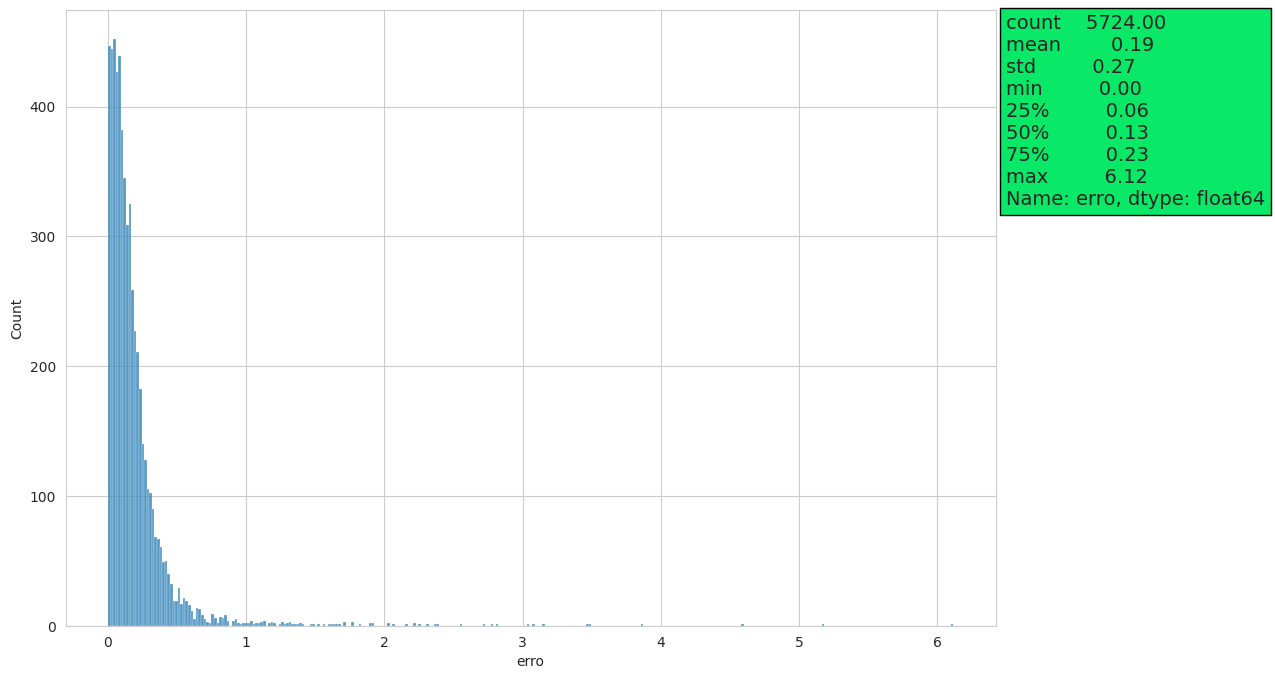

In [149]:
plt.figure(figsize=(12,8))
sns.histplot(data=avaliacao,x='erro')

texto = f"{round(avaliacao['erro'].describe(),2)}"
plt.text(6.5,324,texto,size=14,bbox=dict(boxstyle='square',ec= (0,0,0), fc= (9/255, 232/255, 102/255)));

# **Validando o novo modelo**

In [92]:
model_pipeline.steps.pop()
model_pipeline.steps.append(('modelo',modelo.models['Catboost']))
reg = model_pipeline

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('categoricos',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder()),
                                                                  ('inputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['fabricante', 'cor',
                                                   'combustivel_secundario',
                                                   'combustivel_primario',
                                                   'tipo_carroceria', 'estado',
                                                   'tracao', 'regiao']),
                                                 ('numericos',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['transmissao', 'odometro',
                                                   'adaptado_gas',
                                                   'capacidade_motor',
                                                   'garantia', 'troca',
                                                   'n_fotos', 'atualizacoes',
                                                   'f0', 'f1', 'f2', 'f3', 'f4',
                                                   'f5', 'f6', 'f7', 'f8', 'f9',
                                                   'dias_listado', 'idade',
                                                   'qt_combustivel'])])),
                ('modelo',
                 <catboost.core.CatBoostRegressor object at 0x7f5f691f0490>)])

In [93]:
reg.fit(X_train,np.log(y_train))

predito = np.exp(reg.predict(X_test))


avaliacao = X_test.copy()

avaliacao['real'] = y_test.copy()
avaliacao['predito'] = predito
avaliacao['erro'] = np.abs(avaliacao['real'] - avaliacao['predito'])/avaliacao['real']

count    5724.000000
mean        0.188409
std         0.272152
min         0.000010
25%         0.059532
50%         0.126693
75%         0.227237
max         6.117439
Name: erro, dtype: float64

Na tabela a seguir podemos notar a diferença entre a validação anterior com todo o dataset e a nova validação depois da limpeza que fizemos. 

Nessa nova validação conseguimos diminuir nosso erro percentual médio de 36% para 18,8%, e dessa forma alcançamos a meta de ter um erro percentual médio de no máximo 20\%. Além da média observamos também os quartis, onde 75\% dos erros são menores que 22,7\%.

In [98]:
pd.concat([avaliacao_base['erro'].describe().to_frame(name ='Validação antiga'),avaliacao['erro'].describe().to_frame(name ='Validação nova')],axis=1)

,Validação antiga,Validação nova
count,7699.000000,5724.000000
mean,0.362636,0.188409
std,8.379750,0.272152
min,0.000017,0.000010
25%,0.065631,0.059532
50%,0.142995,0.126693
75%,0.266340,0.227237
max,589.541875,6.117439


Abaixo estão alguns quartis além dos expostos pelo método describe.

In [157]:
avaliacao['erro'].quantile([0.8,0.9,0.92,0.95, 0.97, 0.98 ,0.99]).to_frame()

,erro
0.80,0.260223
0.90,0.374309
0.92,0.414884
0.95,0.513942
0.97,0.659983
0.98,0.824796
0.99,1.258034


<AxesSubplot: xlabel='real', ylabel='predito'>

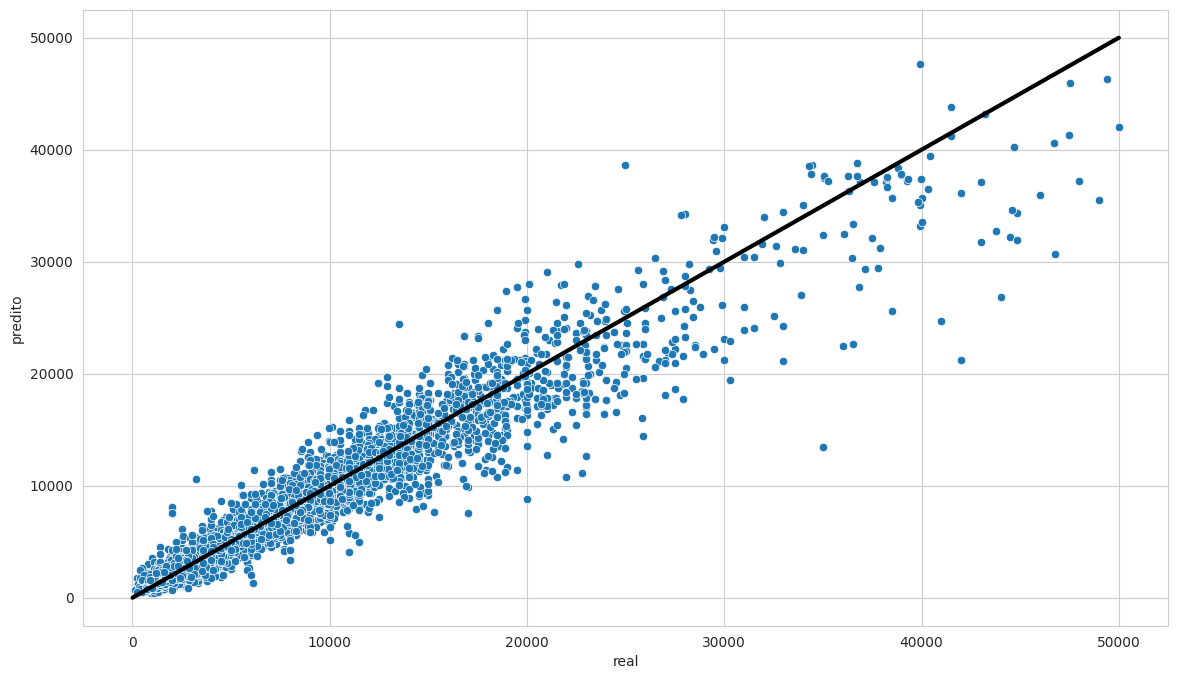

In [96]:
plt.figure(figsize=(14,8))
sns.scatterplot(data=avaliacao, x='real',y='predito')
sns.lineplot(x=[0,50000],y=[0,50000],linewidth=3,c='black')

### **Considerações em relação aos erros**

Vimos nas analises anteriores que os erros se acumularam nos veiculos cujo preço é menor e isso não necessáriamente é problema do nosso modelo mas sim nas métricas utilizadas. Estamos predizendo preços em varias ordens de grandezas diferentes e demandar que o erro percentual médio esteja abaixo de 20% para todas as escalas no problema é injusto. Vamos discorrer sobre isso nas próximas celulas

Vamos considerar 3 preços em 3 escalas diferentes: \$500, \$5000, \$50000.

respectivamente 20\% de cada um desses 3 preços é:

1. 20\% de 500 = 100

2. 20\% de 5000 = 1000

3. 20\% de 50000 = 10000

E aqui vemos um dos problemas dessa métrica. Para 500 o modelo só tem liberdade para errar em 100 unidades, isso é, se ele predizer valores acima de 600 ou abaixo de 400 o erro já será maior que 20\%. 

Em contrapartida, para 5000 o modelo tem uma liberdade de erro maior, podendo errar em até mil unidades.

Para 50000 essa faixa é ainda maior, podendo errar até 10mil unidades e assim por diante. 

E devido a essa caracteristica de valores percentuais que nosso erros podem estar passando dos 20\% estabelecidos para valores de preço mais baixos. 

Para contornar esse problema devemos visualizar outras métricas, e por isso que antes de inicar a modelagem nós estabelecemos também o erro médio absoluto. 

Para finalizar esse projeto, vamos dar uma olhada nas diferenças absolutas entre o real e o predito

In [114]:
avaliacao['diff'] = np.abs(avaliacao['real'] - avaliacao['predito'])

Não vamos nos prolongar nessa analise, entretanto, observamos como a diferença absoluta entre o real e o predito  nos quartis e notamos que a mediana esta em torno de \$700 dolares.

In [137]:
avaliacao[['real','diff']].describe().T

,count,mean,std,min,25%,50%,75%,max
real,5724.0,7966.889202,6759.983289,150.000000,3344.805000,6300.000000,10300.000000,49999.000000
diff,5724.0,1136.091087,1482.892993,0.026949,309.493723,699.819908,1374.661554,21585.008463


# **Interpretando o modelo**

Já obtivemos um resultado excelente na validação, agora para finalizar com chave de ouro desejamos entender quais features o modelo considera mais importantes. No gráfico abaixo podemos observar quais as features mais relevantes para o nosso modelo Catboost, onde a idade é de longe a variável mais importante considerada por ele.


Observação: A feature que criamos (qt_combustivel) não foi nada relevante para o modelo.

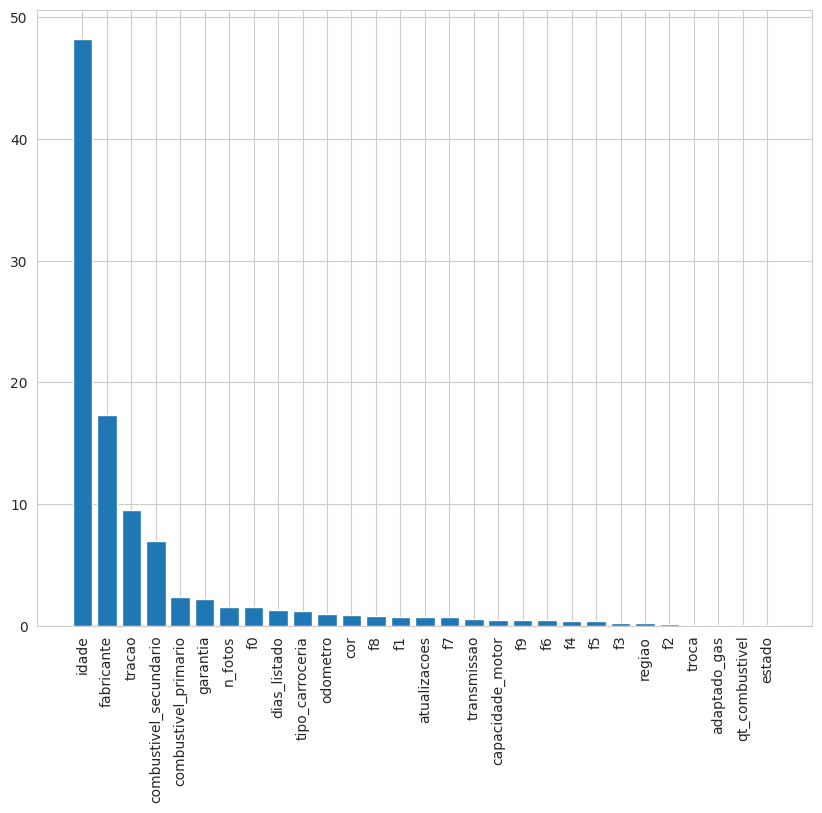

In [237]:
importancias = pd.DataFrame({'importancia': reg.steps[-1][1].get_feature_importance(), 
              'feature': X_test.columns}).sort_values(by=['importancia'], 
                                                           ascending=False)
plt.figure(figsize=(10,8));
plt.xticks(rotation=90);
plt.bar(x=importancias['feature'],height=importancias['importancia']);                                                        

# **Conclusão** 

# **Considerações finais**